### Turbidity Estimation using test set sampled images

In [1]:
%matplotlib widget
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import numpy as np
import collections
import glob
import os
import sys 
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
sys.path.insert(0, '../dip_utils')
from matrix_utils import arr_info
from vis_utils import (vis_pair, 
                       vis_triple)
%run watershed.ipynb
%run calibrate.ipynb
%run greyscale.ipynb
%run image_stacking.ipynb
%run whitep_elimination.ipynb

In [2]:
path = '../test_images/'
dest = '../stacked_test/'
clear = '../stacked_new/NTU0.jpg'

In [3]:
%%bash
cd ../stacked_test/
rm -r *

In [4]:
image_stacking(path, dest)

In [5]:
image = []
filename = []
for dic in os.listdir(dest):
    if dic != '.ipynb_checkpoints':
        filename.append(dic)
for dic in os.listdir(dest):
    d = os.path.join(dest, dic)  # directory of water samples
    if not d.endswith('.ipynb_checkpoints'):
        img = plt.imread(d)
        image.append(img)

In [6]:
img_lib = {}
for i in range(len(filename)):
    img_lib[filename[i]] = image[i]

In [7]:
markers_lib = dict()
for img in img_lib:
    markers = watershed(dest, img)
    markers_lib[img] = markers

In [8]:
bottom_lib = dict()
left_lib = dict()
top_lib = dict()
right_lib = dict()

In [9]:
# Acquire the bottom and the leftmost point of the ROI
# Also acquire the right and top part of the ROI for resize purposes.
for key in markers_lib:
    bottom = np.where(markers_lib[key]==1)[0].max()
    bottom_lib[key] = bottom
    top = np.where(markers_lib[key]==2)[0].min()
    top_lib[key] = top
    left = np.where((markers_lib[key]!=1) & (markers_lib[key]!=-1))[1].min()
    left_lib[key] = left
    right = np.where((markers_lib[key]!=1) & (markers_lib[key]!=-1))[1].max()
    right_lib[key] = right
    
ref_b = bottom_lib['NTU0.jpg']
ref_t = top_lib['NTU0.jpg']
ref_l = left_lib['NTU0.jpg']
ref_r = right_lib['NTU0.jpg']
ratio_ref = (ref_b - ref_t) / (ref_r - ref_l)

In [10]:
# Some threshold values
envir = ['NTU19_0.jpg', 'NTU3_18.jpg', 'NTU4_05.jpg']
# 550 50 80 350
vert_thres = 550
horz_thres = 50
length = 80
dist = 350

In [11]:
# Avoid Extracting incorrect ROI
for key in markers_lib:
    while markers_lib[key][bottom_lib[key]-vert_thres, left_lib[key]+horz_thres] == 1:
        left_lib[key] += horz_thres
    if key in envir:
        left_lib[key] += 3*horz_thres
left_lib

{'NTU164.jpg': 192,
 'NTU74_5.jpg': 260,
 'NTU108.jpg': 199,
 'NTU137.jpg': 153,
 'NTU50_5.jpg': 210,
 'NTU35_2.jpg': 205,
 'NTU334.jpg': 241,
 'NTU263.jpg': 253,
 'NTU185.jpg': 222,
 'NTU358.jpg': 121,
 'NTU214.jpg': 224,
 'NTU160.jpg': 166,
 'NTU65_3.jpg': 78,
 'NTU374.jpg': 208,
 'NTU43_3.jpg': 204,
 'NTU148.jpg': 209,
 'NTU235.jpg': 193,
 'NTU127.jpg': 120,
 'NTU323.jpg': 131,
 'NTU0.jpg': 242,
 'NTU296.jpg': 158,
 'NTU417.jpg': 183}

In [12]:
# Calibration
calibrated = {}
for img in img_lib:
    org = plt.imread(os.path.join(dest, img))
    org = lab_trans(clear, org)
    calibrated[img] = org

In [13]:
greyscale = {}
for img in img_lib:
    grey = calibrated[img]
    grey = to_single_channel(grey)
    greyscale[img] = grey

In [14]:
# x_left represents the ROI of the reference, while x_right represents the ROI of the sample
x_left = []
x_right = []
y_left = []
y_right = []

In [15]:
vert_d = dict()
horz_d = dict()
length_d = dict()
dist_d = dict()
for key in greyscale:
    sample_b = bottom_lib[key]
    sample_t = top_lib[key]
    sample_l = left_lib[key]
    sample_r = right_lib[key]
    ratio_width = (sample_r - sample_l) / (ref_r - ref_l)
    ratio_height = (sample_b - sample_t) / (ref_b - ref_t)
    vert_d[key] = int(vert_thres*ratio_height)
    horz_d[key] = horz_thres
    length_d[key] = int(length*ratio_height)
    dist_d[key] = dist

In [16]:
for key in greyscale:
    x = []
    x1 = []
    y = []
    y1 = []
    for i in range(bottom_lib[key], bottom_lib[key]-vert_d[key], -1):
        x.append(i)
        y.append(np.mean(greyscale[key][i-1:i, left_lib[key]+horz_d[key]:left_lib[key]+horz_d[key]+length_d[key]]))
    x_left.append(x)
    y_left.append(y)
    for i in range(bottom_lib[key], bottom_lib[key]-vert_d[key], -1):
        x1.append(i)
        y1.append(np.mean(greyscale[key][i-1:i, left_lib[key]+horz_d[key]+dist_d[key]:
                                         left_lib[key]+horz_d[key]+dist_d[key]+length_d[key]]))
    x_right.append(x1)
    y_right.append(y1)

In [17]:
# plot the ratio with respect to NTU
num = []
for img in img_lib:
    img = img.replace('_', '.')
    a = img.split('NTU')
    a = [b.split('.jpg') for b in a]
    for item in a:
        item.remove("")
    num.append(a)

In [18]:
NTU = []
for i in num:
    for j in i:
        if len(j) != 0:
            NTU.append(float(j[0]))

In [19]:
f = open('../assets/theta.txt')
thresholds = f.readlines()
for i in range(len(thresholds)):
    thresholds[i] = thresholds[i].strip()
    thresholds[i] = float(thresholds[i])

In [22]:
diff = []
for i in range(len(x_left)):
    s = 0
    mean = 0
    for j in range(len(x_left[i])):
        s += (y_right[i][j] - y_left[i][j])
    mean = s / len(x_left[i])
    diff.append(abs(mean))
diff

[30.321892393320987,
 22.022765598650945,
 24.703726056153247,
 31.698219086021503,
 19.581041937785972,
 14.443897435897414,
 56.18070364387008,
 41.75352193862254,
 33.765721947628585,
 58.43718525352706,
 36.427045111159046,
 30.95429102310997,
 11.159159223634504,
 59.82700812274369,
 17.32226645812597,
 32.71408256485393,
 43.652779709741694,
 29.691528351166937,
 55.455118904939134,
 4.141022727272728,
 50.09032039711193,
 61.56401777777779]

In [23]:
for i in range(len(diff)):
    diff[i] -= thresholds[0]

In [24]:
correction = abs(thresholds[2] / thresholds[1])
correction

5.018493310018847

In [25]:
estimated = [abs(round(diff[i]*thresholds[1]+thresholds[2], 2)) for i in range(len(diff))]

In [26]:
pair = dict(zip(NTU, estimated))

In [27]:
od_NTU = []
od_estimated = []
for key, value in sorted(pair.items()):
    od_NTU.append(key)
    od_estimated.append(value)

In [28]:
r2 = r2_score(od_NTU, od_estimated)
r2 = round(r2, 3)

In [29]:
df = pd.DataFrame(list(zip(od_NTU, od_estimated)),
               columns =['Actual_NTU', 'Estimated_NTU'])

In [30]:
df['R^2'] = r2
df

,Actual_NTU,Estimated_NTU,R^2
0,0.0,12.06,0.955
1,35.2,59.37,0.955
2,43.3,79.33,0.955
3,50.5,94.99,0.955
4,65.3,36.60,0.955
5,74.5,111.91,0.955
6,108.0,130.50,0.955
7,127.0,165.08,0.955
8,137.0,179.00,0.955
9,148.0,186.04,0.955


In [31]:
df.to_csv('../assets/prediction.csv')

In [32]:
# Figure 10
model = ols('Estimated_NTU ~ Actual_NTU', data=df).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Estimated_NTU   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     718.5
Date:                Sun, 09 Oct 2022   Prob (F-statistic):           3.79e-17
Time:                        17:19:49   Log-Likelihood:                -95.320
No. Observations:                  22   AIC:                             194.6
Df Residuals:                      20   BIC:                             196.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.9496      7.618      3.932      0.0

eval_env: 1


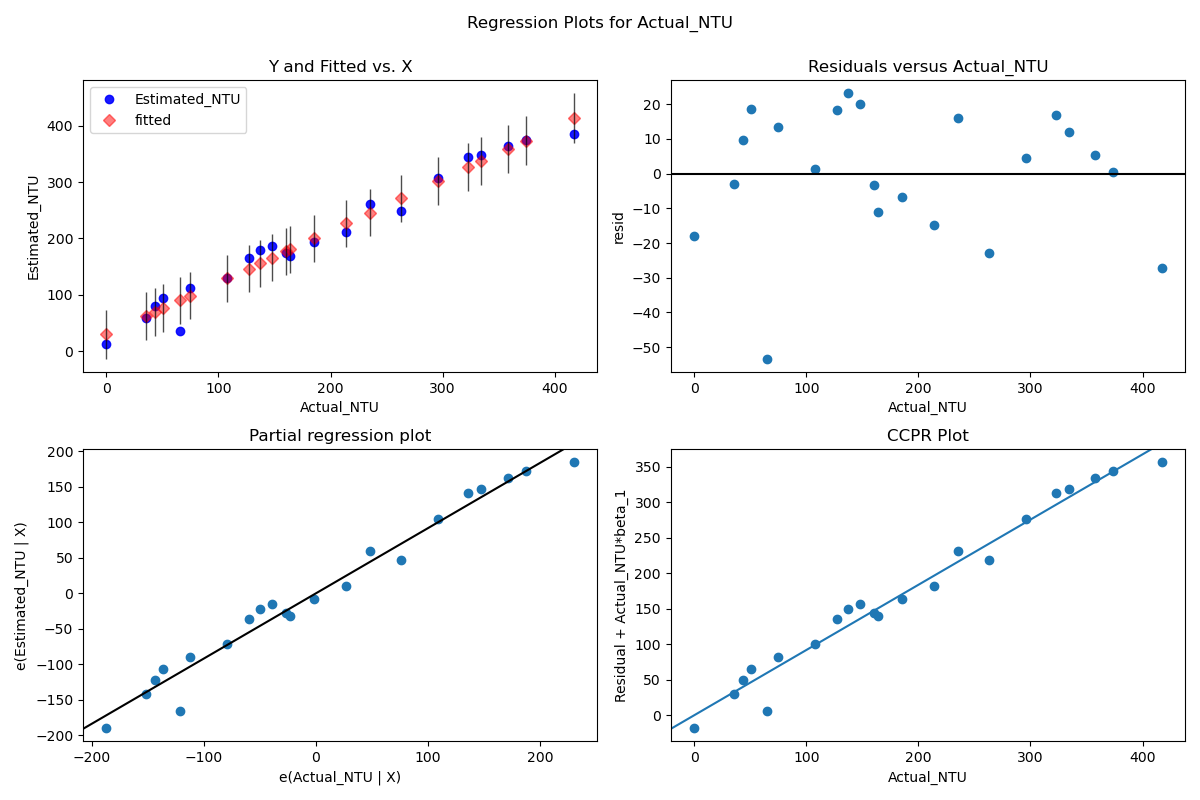

In [33]:
# Figure 9
#define figure size
fig = plt.figure(figsize=(12,8))

#produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'Actual_NTU', fig=fig)
plt.savefig('../assets/test_fit.pdf', dpi=600)
plt.show()